In [9]:
#!pip install torch torchvision
#!pip install 'git+https://github.com/facebookresearch/detectron2.git'
import torch, torchvision

cuda_bool=torch.cuda.is_available()

print(f"Pytorch version: {torch.__version__}")
if cuda_bool:
    print("Cuda device available")
else:
    print("Cuda device NOT available")

Pytorch version: 1.7.1
Cuda device available


In [10]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

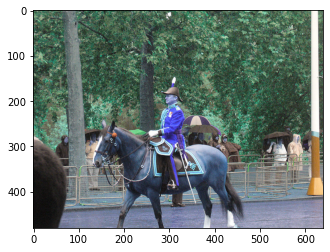

In [11]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")
plt.imshow(im)

In [12]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
if not cuda_bool:
    cfg.MODEL.DEVICE="cpu"
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

In [13]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([17,  0,  0,  0,  0,  0,  0,  0, 25,  0, 25, 25,  0,  0, 24],
       device='cuda:0')
Boxes(tensor([[126.6035, 244.8977, 459.8292, 480.0000],
        [251.1083, 157.8127, 338.9731, 413.6379],
        [114.8496, 268.6864, 148.2352, 398.8111],
        [  0.8217, 281.0327,  78.6072, 478.4210],
        [ 49.3954, 274.1229,  80.1545, 342.9808],
        [561.2248, 271.5816, 596.2755, 385.2552],
        [385.9072, 270.3125, 413.7130, 304.0397],
        [515.9295, 278.3744, 562.2792, 389.3803],
        [335.2409, 251.9167, 414.7491, 275.9375],
        [350.9300, 269.2060, 386.0984, 297.9081],
        [331.6292, 230.9996, 393.2759, 257.2009],
        [510.7349, 263.2656, 570.9865, 295.9194],
        [409.0841, 271.8646, 460.5582, 356.8722],
        [506.8766, 283.3257, 529.9403, 324.0392],
        [594.5663, 283.4820, 609.0577, 311.4124]], device='cuda:0'))


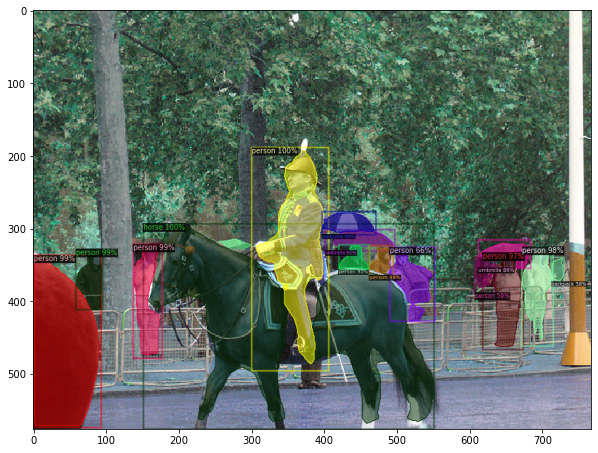

In [14]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(10,10))
plt.imshow(out.get_image()[:, :, ::-1])

In [15]:
# Prepare dataset
# Load dataset info
import pandas as pd

pd.read_csv("df_train_info_detectron2.csv")

,image_id,CategoryId,EncodedPixels,Height,Width
0,b1c3165220a76f6359ab3351cc21bf1c,[0],[],2500,2048
1,7d06c9906257d557aa101e9c73cb10e6,[0],[],2527,2178
2,7bee8aa7c75305b6231950b2a22f4356,[0],[],2475,2484
3,9f9540fc6cacfafb232878e33ce1d8e3,[0],[],3028,2517
4,510bd037beda94d973e885d2c3896d56,[0],[],3408,2680
...,...,...,...,...,...
11995,79c5d4d7f3b2e7a5a183bfbe664c699d,"[7, 8, 5, 7, 5, 7, 8, 8, 7, 14]","[[1644.0, 1333.0, 2052.0, 1701.0], [326.0, 153...",2880,2304
11996,30cdc2c88638bc0f0e61892625a19a94,[0],[],2836,2336
11997,551456e08a1327bdba41297c8ebb8c6f,"[1, 12, 11, 4, 10, 4, 12, 1, 4, 1]","[[1377.0, 869.0, 1784.0, 1347.0], [158.0, 1934...",2760,2676
11998,e03f7ae2393dd3335154562ba6419f74,[0],[],2328,2495


In [16]:
from detectron2.structures import BoxMode
import ast

def get_xray_dicts(df, img_dir):
    
    df.EncodedPixels=df.EncodedPixels.apply(ast.literal_eval)
    df.CategoryId=df.CategoryId.apply(ast.literal_eval)
    dataset_dicts = []
    for idx, v in df.iterrows():
        record = {}
        
        filename = os.path.join(img_dir, v["image_id"]+".jpg")
        #print(filename)
        height, width = v["Height"] ,v["Width"]#cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["EncodedPixels"]
        objs = []
        for idx,anno in enumerate(annos):
            if len(anno)>0:
                poly = [(anno[0], anno[1]),(anno[0], anno[3]),(anno[2], anno[3]),(anno[2], anno[1]),(anno[0], anno[1])]
                poly = [(x + 0.5, y + 0.5) for x, y in poly]
                poly = [p for x in poly for p in x]

                obj = {
                    "bbox": [anno[0], anno[1], anno[2], anno[3]],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "segmentation": [poly],
                    "category_id": v["CategoryId"][idx]-1, # In the dataframe, 0 means background. For detectron, no need to specify background
                }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


PATH_INPUT = "/home/jupyter/DATA/"
PATH_TRAIN_IMAGES = PATH_INPUT+"train/"
PATH_TRAIN_IMAGES_RESIZED=PATH_INPUT+"no_resized/"

labels_info=pd.read_csv("labels_info.csv")

for d in ["train", "val"]:
    DatasetCatalog.register("xray_" + d, lambda d=d: get_xray_dicts(pd.read_csv(f"df_{d}_info_detectron2.csv"),PATH_TRAIN_IMAGES_RESIZED))
    MetadataCatalog.get("xray_" + d).set(thing_classes=labels_info.class_name.to_list())
    
# DatasetCatalog.register("xray_train", get_xray_dicts(pd.read_csv(f"df_train_info_detectron2.csv"),PATH_TRAIN_IMAGES_RESIZED))
# MetadataCatalog.get("xray_train").set(thing_classes=labels_info.class_name.to_list())
# DatasetCatalog.register("xray_val", get_xray_dicts(pd.read_csv(f"df_val_info_detectron2.csv").iloc[:1000],PATH_TRAIN_IMAGES_RESIZED))
# MetadataCatalog.get("xray_val").set(thing_classes=labels_info.class_name.to_list())
xray_metadata = MetadataCatalog.get("xray_train")

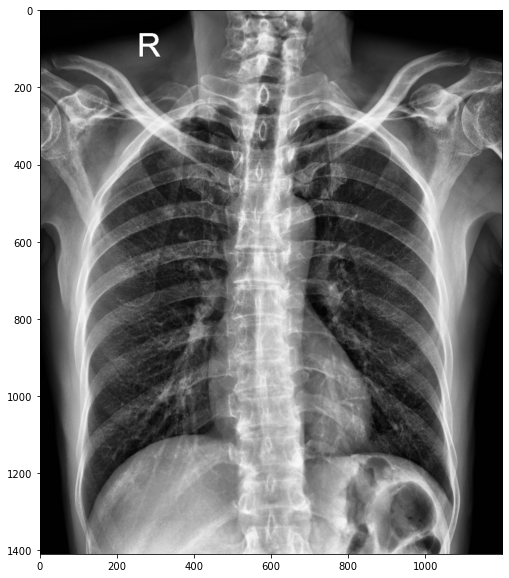

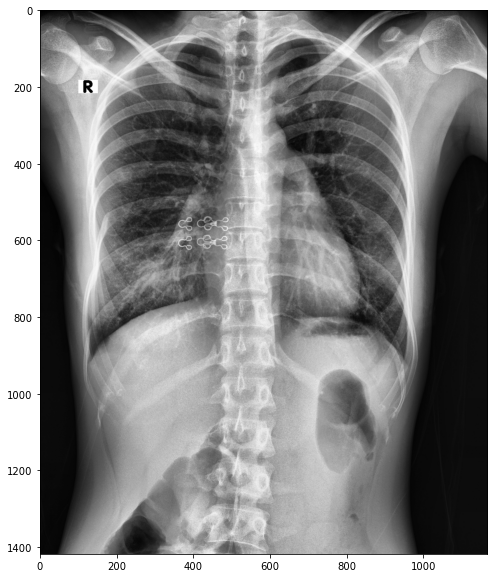

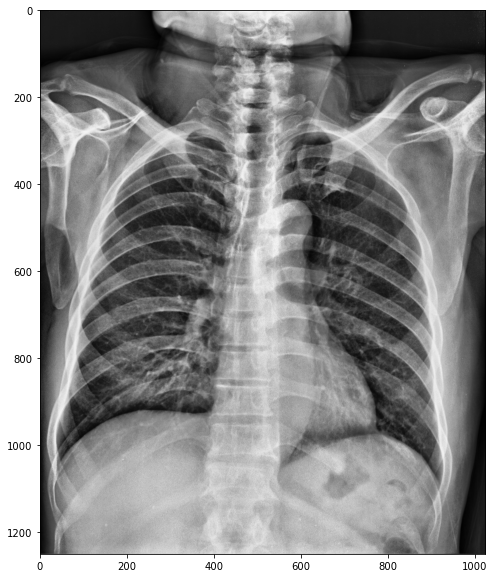

In [17]:
dataset_dicts = get_xray_dicts(pd.read_csv(f"df_val_info_detectron2.csv"),PATH_TRAIN_IMAGES_RESIZED)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=xray_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(10,10))
    plt.imshow(out.get_image()[:, :, ::-1])

In [18]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
from detectron2.evaluation import COCOEvaluator
from detectron2.engine import DefaultTrainer
import torch
import time
import datetime

In [19]:
# training
class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)
        
        
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks
    

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("xray_train",)
cfg.DATASETS.TEST = ("xray_val",)
cfg.TEST.EVAL_PERIOD = 500
cfg.DATALOADER.NUM_WORKERS = 8
if not cuda_bool:
    cfg.MODEL.DEVICE="cpu" #For CPU
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 20000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.SEED=1234
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg) 

[01/16 09:49:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [ ]:
trainer.resume_or_load(resume=False)
trainer.train()

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (15, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (15,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (56, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (56,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (14, 256, 1, 

[01/16 09:50:05 d2.engine.train_loop]: Starting training from iteration 0
[01/16 09:51:34 d2.utils.events]:  eta: 23:58:52  iter: 19  total_loss: 4.575  loss_cls: 2.784  loss_box_reg: 0.07691  loss_mask: 0.6916  loss_rpn_cls: 0.9089  loss_rpn_loc: 0.08384  time: 4.4041  data_time: 0.0871  lr: 4.9953e-06  max_mem: 8958M
[01/16 09:53:08 d2.utils.events]:  eta: 1 day, 1:32:04  iter: 39  total_loss: 4.13  loss_cls: 2.54  loss_box_reg: 0.09914  loss_mask: 0.6908  loss_rpn_cls: 0.704  loss_rpn_loc: 0.08582  time: 4.5627  data_time: 0.0207  lr: 9.9902e-06  max_mem: 8958M
[01/16 09:54:49 d2.utils.events]:  eta: 1 day, 2:12:13  iter: 59  total_loss: 3.544  loss_cls: 2.114  loss_box_reg: 0.1143  loss_mask: 0.6897  loss_rpn_cls: 0.536  loss_rpn_loc: 0.07841  time: 4.7256  data_time: 0.0204  lr: 1.4985e-05  max_mem: 8958M
[01/16 09:56:28 d2.utils.events]:  eta: 1 day, 2:42:25  iter: 79  total_loss: 2.808  loss_cls: 1.505  loss_box_reg: 0.1187  loss_mask: 0.6866  loss_rpn_cls: 0.384  loss_rpn_loc: 

In [ ]:
# Inference
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_xray_dicts(pd.read_csv(f"df_train_info_detectron2.csv"),PATH_TRAIN_IMAGES_RESIZED)
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=xray_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(20,20))
    plt.imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("xray_val", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "xray_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))